## AEMET OpenData extraction

### This notebook aims to automatize the extraction of meteorological data from the official [AEMET](https://opendata.aemet.es/centrodedescargas/inicio) open data webpage using your personal API key.

### It is prepared to fix the desired dates, then all the available data is extracted respecting:
<ol>
  <li>The maximal amount of days that can be extracted in one query</li>
  <li>The minimal time between requests</li>
</ol>

In [1]:
# Import the modules
from datetime import datetime, timedelta
import requests
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Setup the requesting info

In [2]:
# Define your personal API key
api_key = ''

# Define the parameters for the request
query_string = {'api_key': api_key}
headers = {'cache-control': 'no-cache'}

In [3]:
# Function to extract the data from the AEMET REST API
def extract_data(query_string, headers, ini_date, end_date):
    # Define the AEMET URL
    url = 'https://opendata.aemet.es/opendata/api/valores/climatologicos/diarios/datos/fechaini/'+ini_date+'T00%3A00%3A00UTC/fechafin/'+end_date+'T23%3A59%3A59UTC/estacion/1207U'
    
    # Request the info from the url
    response = requests.request('GET', url, headers = headers, params = query_string)
    
    # Check the state of the query
    print(response.text)

    # Parse the JSON data
    json_data = response.json()
    
    # Access the metadata and data (python dictionaries)
    metadata = requests.get(json_data['metadatos']).json()
    data = requests.get(json_data['datos']).json()
    return metadata, data

In [4]:
# Select the initial date, format = yyyy-mm-dd
ini_date = '2015-01-01'
end_date = '2023-12-31'

# Convert strings to datetime objects
d1 = datetime.strptime(ini_date, '%Y-%m-%d')
d2 = datetime.strptime(end_date, '%Y-%m-%d')

# Difference in number of days
difference = (d2 - d1).days
print('N_days =', difference)

n_max = 183 # The maximal amount of days that we can extract from AEMET
if difference > n_max:
    n = difference//n_max

# Number of years in the query
n_years, r = difference//366, difference%366 # We take 366 days to take into account the leap-years

N_days = 3286


### Extract and save the data

In [5]:
# Save the data in a list and finally convert it into a dataframe for a faster performance
data_list = []
# Loop to extract the data
for _ in range(n):
    # Compute the end date
    d2 = d1 + timedelta(days = n_max)
    end_date = d2.strftime('%Y-%m-%d')

    # Obtain the data
    metadata, data = extract_data(query_string, headers, ini_date, end_date)

    # Save the data in a list
    data_list += data

    # Redefine the initial date
    d1 += timedelta(days = n_max + 1)
    ini_date = d1.strftime('%Y-%m-%d')
    difference -= (n_max + 1)

    # Wait for the next request
    time.sleep(5) # 5 seconds

if difference > 0:
    # Obtain the data of the remaining days
    d2 = d1 + timedelta(days = difference)
    end_date = d2.strftime('%Y-%m-%d')
    metadata, data = extract_data(query_string, headers, ini_date, end_date)
    data_list += data

# Define the data in a pandas dataframe
df = pd.DataFrame(data_list)
print('N_days, N_features =', df.shape)
df.head()

{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/b047054a",
  "metadatos" : "https://opendata.aemet.es/opendata/sh/b3aa9d28"
}
{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/13abebd6",
  "metadatos" : "https://opendata.aemet.es/opendata/sh/b3aa9d28"
}
{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/3267bbc0",
  "metadatos" : "https://opendata.aemet.es/opendata/sh/b3aa9d28"
}
{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/8bfae889",
  "metadatos" : "https://opendata.aemet.es/opendata/sh/b3aa9d28"
}
{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/b8e5336c",
  "metadatos" : "https://opendata.aemet.es/opendata/sh/b3aa9d28"
}
{
  "descripcion" : "exito",
  "estado" : 200,
  "datos" : "https://opendata.aemet.es/opendata/sh/f383ed46",
  "metadato

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,...,sol,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2015-01-01,1207U,"GIJÓN, CAMPUS",ASTURIAS,26,"6,4","0,0","-1,8",07:20,"14,6",...,"3,3","1034,2",24,"1031,6",05,82,99,08:30,52,12:40
1,2015-01-02,1207U,"GIJÓN, CAMPUS",ASTURIAS,26,"7,9","0,0","-0,2",04:40,"16,0",...,"0,5","1036,7",10,"1033,7",01,81,99,05:00,49,14:30
2,2015-01-03,1207U,"GIJÓN, CAMPUS",ASTURIAS,26,"8,0","0,0","0,4",Varias,"15,7",...,"2,2","1034,8",24,"1033,4",Varias,84,100,Varias,59,12:50
3,2015-01-04,1207U,"GIJÓN, CAMPUS",ASTURIAS,26,"9,4","0,0","4,1",06:30,"14,7",...,"0,4","1034,8",00,"1028,2",24,90,100,Varias,77,14:20
4,2015-01-05,1207U,"GIJÓN, CAMPUS",ASTURIAS,26,"9,7","0,0","3,6",06:20,"15,8",...,"2,1","1028,2",00,"1022,3",14,88,100,Varias,64,13:50


In [6]:
# Print some info of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3284 entries, 0 to 3283
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   fecha        3284 non-null   object
 1   indicativo   3284 non-null   object
 2   nombre       3284 non-null   object
 3   provincia    3284 non-null   object
 4   altitud      3284 non-null   object
 5   tmed         3197 non-null   object
 6   prec         3131 non-null   object
 7   tmin         3197 non-null   object
 8   horatmin     3197 non-null   object
 9   tmax         3197 non-null   object
 10  horatmax     3197 non-null   object
 11  dir          3191 non-null   object
 12  velmedia     3260 non-null   object
 13  racha        3191 non-null   object
 14  horaracha    3191 non-null   object
 15  sol          3227 non-null   object
 16  presMax      3149 non-null   object
 17  horaPresMax  3149 non-null   object
 18  presMin      3146 non-null   object
 19  horaPresMin  3146 non-null 

### Some basic data cleaning (Erase unimportant, Handle Nulls, NaNs, Change Object-to-Floating values)

In [7]:
# Drop unnecessary columns
df = df.drop(['indicativo', 'nombre', 'provincia', 'altitud', 'dir', 'racha', 'horaracha', 'sol'], axis = 1)

# Erase the Ip (less than 0.1 mm) values in prec column
df['prec'] = df['prec'].replace('Ip', '0')

# Convert to date time format
df['fecha'] = pd.to_datetime(df['fecha'], format = '%Y-%m-%d')

# Convert to floats
fields = ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'presMax', 'presMin', 'hrMax', 'hrMin']
for field in fields:
    df[field] = df[field].str.replace(',', '.').astype(float)

print('N_days, N_features =', df.shape)
df.head()

N_days, N_features = (3284, 17)


,fecha,tmed,prec,tmin,horatmin,tmax,horatmax,velmedia,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2015-01-01,6.4,0.0,-1.8,07:20,14.6,14:40,1.7,1034.2,24,1031.6,05,82,99.0,08:30,52.0,12:40
1,2015-01-02,7.9,0.0,-0.2,04:40,16.0,14:40,0.6,1036.7,10,1033.7,01,81,99.0,05:00,49.0,14:30
2,2015-01-03,8.0,0.0,0.4,Varias,15.7,13:40,1.9,1034.8,24,1033.4,Varias,84,100.0,Varias,59.0,12:50
3,2015-01-04,9.4,0.0,4.1,06:30,14.7,14:40,1.4,1034.8,00,1028.2,24,90,100.0,Varias,77.0,14:20
4,2015-01-05,9.7,0.0,3.6,06:20,15.8,13:50,1.1,1028.2,00,1022.3,14,88,100.0,Varias,64.0,13:50


In [8]:
# Erase the nulls
df.dropna(inplace = True, ignore_index = True)
print('N_days, N_features =', df.shape)
df.head()

N_days, N_features = (3058, 17)


,fecha,tmed,prec,tmin,horatmin,tmax,horatmax,velmedia,presMax,horaPresMax,presMin,horaPresMin,hrMedia,hrMax,horaHrMax,hrMin,horaHrMin
0,2015-01-01,6.4,0.0,-1.8,07:20,14.6,14:40,1.7,1034.2,24,1031.6,05,82,99.0,08:30,52.0,12:40
1,2015-01-02,7.9,0.0,-0.2,04:40,16.0,14:40,0.6,1036.7,10,1033.7,01,81,99.0,05:00,49.0,14:30
2,2015-01-03,8.0,0.0,0.4,Varias,15.7,13:40,1.9,1034.8,24,1033.4,Varias,84,100.0,Varias,59.0,12:50
3,2015-01-04,9.4,0.0,4.1,06:30,14.7,14:40,1.4,1034.8,00,1028.2,24,90,100.0,Varias,77.0,14:20
4,2015-01-05,9.7,0.0,3.6,06:20,15.8,13:50,1.1,1028.2,00,1022.3,14,88,100.0,Varias,64.0,13:50


## Perform a simple EDA of the temperatures and the amount of rainfall

In [9]:
# Metadata is important to check some info of the data
print('Metadata keys:')
print(metadata.keys())
print('')
print('Info of the first column in the dataframe:')
print(metadata['campos'][0])

Metadata keys:
dict_keys(['unidad_generadora', 'periodicidad', 'descripcion', 'formato', 'copyright', 'notaLegal', 'campos'])

Info of the first column in the dataframe:
{'id': 'fecha', 'descripcion': 'fecha del dia (AAAA-MM-DD)', 'tipo_datos': 'string', 'requerido': True}


In [10]:
df.columns

Index(['fecha', 'tmed', 'prec', 'tmin', 'horatmin', 'tmax', 'horatmax',
       'velmedia', 'presMax', 'horaPresMax', 'presMin', 'horaPresMin',
       'hrMedia', 'hrMax', 'horaHrMax', 'hrMin', 'horaHrMin'],
      dtype='object')

In [11]:
# Find the info of a specific field
field = 'prec'
next(item for item in metadata['campos'] if item['id'] == field)

{'id': 'prec',
 'descripcion': 'Precipitación diaria de 07 a 07',
 'tipo_datos': 'float',
 'unidad': 'mm (Ip = inferior a 0,1 mm) (Acum = Precipitación acumulada)',
 'requerido': False}

### Since we have dropped some null values in the dataframe, the years might have less than 365 days, so we need to find where the years end.

In [12]:
# Find the end of each year
def find_complete_year(df):
    idxs = [0]
    Dec_idx = np.where(df['month'] == 'December')[0]
    for idx in Dec_idx:
        try:
            if df.loc[idx+1, 'month'] == 'January':
                idxs.append(idx+1)
        except:
            pass
    return idxs

# Create new columns with the name of the months and the year
df['month'] = df['fecha'].dt.month_name()
df['year'] = df['fecha'].dt.year

# Find the indices where each years ends
end_idxs = find_complete_year(df)

end_idxs

[0, 363, 688, 1053, 1415, 1719, 2003, 2366, 2728]

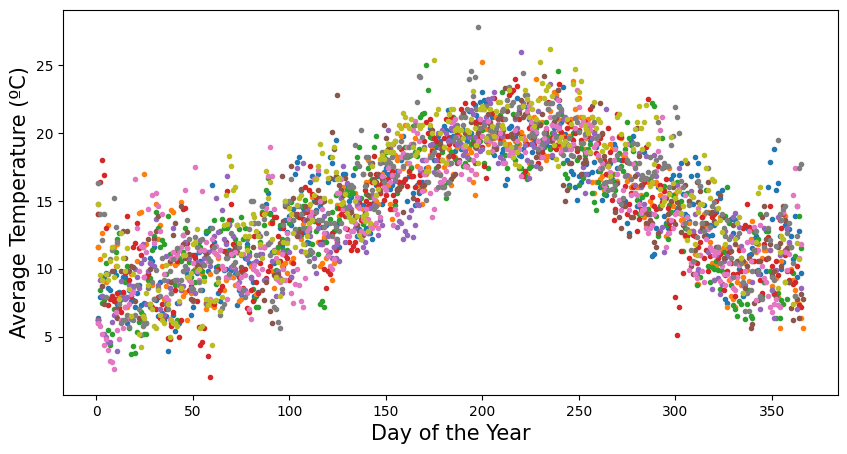

In [13]:
# Plot the average temperature for each day of the year
fig, ax = plt.subplots(figsize = (10, 5))
for i in range(n_years):
    ax.plot(df.loc[end_idxs[i]:end_idxs[i+1], 'fecha'].dt.dayofyear, df.loc[end_idxs[i]:end_idxs[i+1], 'tmed'], '.')
if r != 0:
    ax.plot(df.loc[end_idxs[-1]:, 'fecha'].dt.dayofyear, df.loc[end_idxs[-1]:, 'tmed'], '.')

ax.set_xlabel('Day of the Year', fontsize = 15)
ax.set_ylabel('Average Temperature (ºC)', fontsize = 15)

plt.show()

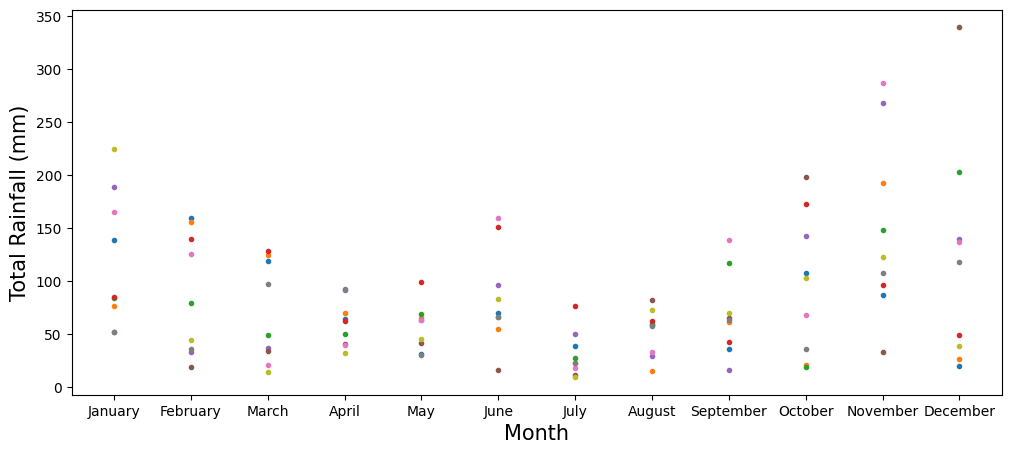

In [14]:
# Plot the total amount of rainfall for each month
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(111)

for i in range(n_years):
    # Group by months in each year
    monthly_rainfall = df[end_idxs[i]:end_idxs[i+1]].groupby(by = 'month')['prec'].sum().reset_index()
    monthly_rainfall['n_month'] = pd.DatetimeIndex(pd.to_datetime(monthly_rainfall['month'], format='%B')).month
    monthly_rainfall = monthly_rainfall.set_index('n_month').sort_index()

    ax.plot(monthly_rainfall['month'], monthly_rainfall['prec'], '.')
if r != 0:
    monthly_rainfall = df[end_idxs[-1]:].groupby(by = 'month')['prec'].sum().reset_index()
    monthly_rainfall['n_month'] = pd.DatetimeIndex(pd.to_datetime(monthly_rainfall['month'], format='%B')).month
    monthly_rainfall = monthly_rainfall.set_index('n_month').sort_index()
    
    ax.plot(monthly_rainfall['month'], monthly_rainfall['prec'], '.')

ax.set_xlabel('Month', fontsize = 15)
ax.set_ylabel('Total Rainfall (mm)', fontsize = 15)

plt.show()

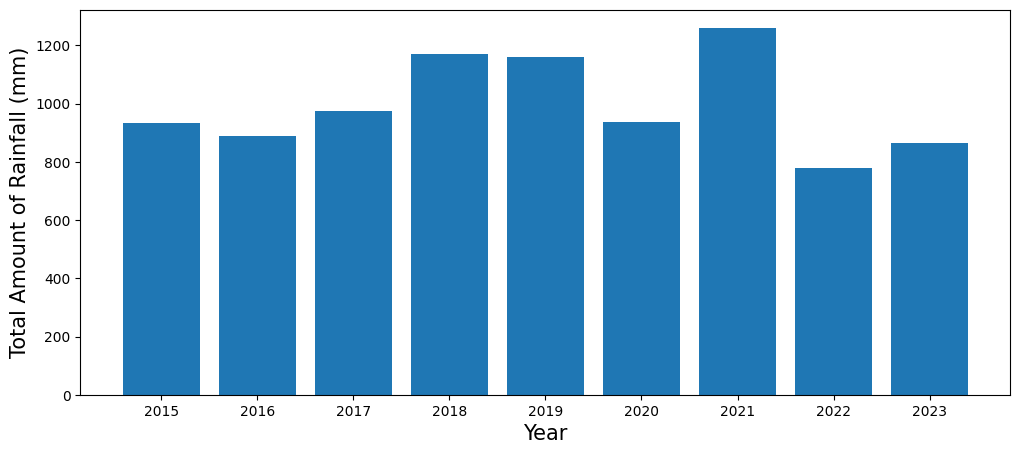

In [15]:
# Find the total amount of rainfaill for each year
fig, ax = plt.subplots(figsize = (12, 5))

yearly_rainfall = df.groupby(by = 'year')['prec'].sum().reset_index()
ax.bar(yearly_rainfall['year'], yearly_rainfall['prec'], tick_label = yearly_rainfall['year'].values)

ax.set_xlabel('Year', fontsize = 15)
ax.set_ylabel('Total Amount of Rainfall (mm)', fontsize = 15)

plt.show()